<a href="https://colab.research.google.com/github/kiakass/machine-learning/blob/main/AML_Midterm_Project_final_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2> Advanced Machine Learning BDC115 </h2>
## - Midterm Project 2021.05.09

### - 빅데이터융합학과 곽준환

## Abstract

### 1.Task Description
>Perform Bayesian linear regression based on the given train dataset in  "train_data.csv”

>A.Input Features: morphological phenotypes from a brain MR image



>> i. Colums D:BU (STxxCV): Cortical Volume of 70 regions, i.e., 70-dimension<br>
>> ii. Colums BV:EM (STxxTA): Average Thickness of 70 regions, i.e., 70-dimension<br>
>> iii. Be aware that there are missing values.<br>
>> iv. If necessary, do your own preprocessing for data cleaning.

>B. Output clinical/cognitive scores: predict the cognitive assessment scores of the subjects in the test dataset of “sample_evaluation_data.csv”.<br>
>> i. Colum A (ADAS11): Alzheimer's Disease Assessment Scale (11 questions version)
[range: 0-70] <br>
>> ii. Colum B (ADAS13): Alzheimer's Disease Assessment Scale (13 questions version)[range: 0-85] <br>
>> iii. Colum C (MMSE): Mini-Mental State Examination [range: 0~30]

### 2.Proejct Requirement
> A. Perform Bayesian linear regression based on the given train dataset in “train_data.csv” <br>

>> i. Free of using basis functions and their functional forms <br>


>B. Analyze and discuss your models and results in markdown cells

### <font color='blue'> 3. Analysis Planning </font>

1. EDA : Explorary Data Analysis
 - 주어진 데이터의 형상, 분포, correlation, missing data 등을 분석함
<br> <br> 

2. Data Preprocessing
 
 - Data 는 기본적으로 missing value 처리 및 normalizing 하여 사용함
 - input data 를 ALL(140), CV(70), TA(70), corr(correlation>30%) 로 구분 
 
 - missing value : drop or replacement
 - normalizing : minmax scaling
 - correlation 이 0.3 보다 큰 filed로 만든 data 구성 
<br> <br> 

3. Model Creation
 - fully bayesian formula 를 사용하여 직접 프로그래밍함
 - function name : Calculate_fully_bayes
<br> <br> 

4. Model comparision
 - Data : ALL, CV, TA, corr data 각각에 대한 성능을 비교함
 - Basis function : <br> 
   1) basic: input x <br>
   2) sigmoid <br>
   3) tanh <br>
   4) swich <br>
   5) softplus <br> 
   를 사용하여 각각의 성능을 비교함
<br> <br> 

5. Parameter 사용
 - Random하게 조합된 [α,β] 로 for loop을 통해 100개의 MAE 구하고 시각화하여 적정하다고 판단되는 α, β값을 사용 하였음



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## I. EDA : Exploratory Data Analysis

### Data loading

In [ ]:
data = 'https://raw.githubusercontent.com/kiakass/share/master/train_data.csv'
df = pd.read_csv(data)

In [ ]:
df.describe()

,ADAS11,ADAS13,MMSE,ST102CV,ST103CV,ST104CV,ST105CV,ST106CV,ST107CV,ST108CV,ST109CV,ST110CV,ST111CV,ST113CV,ST114CV,ST115CV,ST116CV,ST117CV,ST118CV,ST119CV,ST121CV,ST123CV,ST129CV,ST130CV,ST13CV,ST14CV,ST15CV,ST23CV,ST24CV,ST25CV,ST26CV,ST31CV,ST32CV,ST34CV,ST35CV,ST36CV,ST38CV,ST39CV,ST40CV,ST43CV,...,ST34TA,ST35TA,ST36TA,ST38TA,ST39TA,ST40TA,ST43TA,ST44TA,ST45TA,ST46TA,ST47TA,ST48TA,ST49TA,ST50TA,ST51TA,ST52TA,ST54TA,ST55TA,ST56TA,ST57TA,ST58TA,ST59TA,ST60TA,ST62TA,ST64TA,ST72TA,ST73TA,ST74TA,ST82TA,ST83TA,ST84TA,ST85TA,ST90TA,ST91TA,ST93TA,ST94TA,ST95TA,ST97TA,ST98TA,ST99TA
count,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,760.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1606.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,...,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1606.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,760.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.00000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000,1607.000000
mean,10.687623,16.838836,27.197884,3415.757312,1889.919104,3449.139390,2242.814561,3415.616055,2011.142502,7846.479776,2936.383945,11364.592408,8286.555694,1850.807716,13241.149347,18303.506534,11272.752334,9654.012446,8795.275669,1973.545737,778.663348,6454.726316,6077.756067,6185.471064,2221.753578,1726.772869,5499.126322,2536.539515,1743.722914,632.463597,8752.144368,10421.447418,9484.886123,2291.787181,10295.434972,6516.395146,5719.485999,4226.335408,9084.429994,3063.385190,...,2.384760,2.019114,2.475054,1.821200,2.290044,2.648584,2.157642,2.540934,2.361113,2.526049,2.230354,1.456342,1.849313,2.417301,2.253390,2.139604,2.832131,2.154694,2.497071,2.007938,2.486484,2.306683,3.450963,2.125401,1.043959,2.361660,2.538278,2.313991,1.735683,3.314019,2.552358,2.552088,2.25390,2.698467,2.335464,2.077695,2.463360,1.850768,2.264312,2.705311
std,6.564644,9.519048,2.640931,581.050677,338.251043,674.695186,367.721845,684.312622,404.254377,1269.699606,468.884157,1661.823223,1335.890162,448.358620,2068.689775,2513.344508,1794.353279,1419.068470,1408.779918,398.514299,169.764897,985.436973,849.199658,965.356725,476.215463,420.541071,1060.617430,496.723152,461.554683,155.676189,1487.230213,1921.463519,1752.756276,450.197633,1725.348432,830.238911,1011.246790,882.130700,1597.766218,550.916888,...,0.237534,0.177947,0.186057,0.151925,0.194545,0.233070,0.218050,0.401720,0.184786,0.250136,0.195438,0.146903,0.174317,0.199327,0.242965,0.202077,0.279173,0.164407,0.183875,0.199050,0.231863,0.204175,0.405734,0.272570,0.136194,0.226703,0.302780,0.207063,0.162672,0.545333,0.284886,0.231266,0.21027,0.231743,0.247948,0.188536,0.182837,0.158143,0.206316,0.227434
min,0.000000,0.000000,19.000000,1968.000000,790.000000,1757.000000,1105.000000,1499.000000,726.000000,4422.000000,1530.000000,6287.000000,4676.000000,697.000000,6920.000000,8885.000000,5687.000000,5014.000000,4652.000000,484.000000,347.000000,3794.000000,3113.000000,3402.000000,943.000000,538.000000,2639.000000,760.000000,502.000000,195.000000,4394.000000,4678.000000,3976.000000,1146.000000,4994.000000,3157.000000,2190.000000,2244.000000,3528.000000,1491.000000,...,1.661000,1.088000,1.760000,1.266000,1.639000,1.599000,1.240000,1.449000,1.624000,1.708000,1.543000,1.123000,1.317000,1.396000,1.333000,1.475000,1.871000,1.311000,1.693000,1.204000,1.616000,1.562000,1.580000,1.261000,0.630000,1.466000,1.592000,1.504000,1.244000,1.454000,1.660000,1.651000,1.42200,1.772000,1.347000,1.3

### 1.Find missing value
 - data(df) column 수보다 작은 필드 식별함

In [ ]:
df.describe().iloc[0][df.describe().iloc[0] < df.shape[0] ]

ST123CV     760.0
ST24CV     1606.0
ST44CV     1606.0
ST64CV      760.0
ST123TA     760.0
ST24TA     1606.0
ST44TA     1606.0
ST64TA      760.0
Name: count, dtype: float64

> <font color='brown'> 4개는 1개, 4개는 800 여개 missing value 확인함 </font>

### 2.데이터 정규성 검정

In [ ]:
import scipy.stats
scipy.stats.mstats.normaltest(df)[1][:10]  # [0] statistic [1]: pvales

array([2.01046676e-72, 3.98068426e-35, 1.36630508e-39, 9.61411818e-14,
       1.02760418e-04, 1.53378488e-50, 3.24282611e-03, 4.88514553e-08,
       5.86053484e-12, 2.74983922e-16])

* input/target vaule의 p-value 를 보면 대부분의 데이터들이 정규성을 띄고 있음

### 3.Data correlation 확인

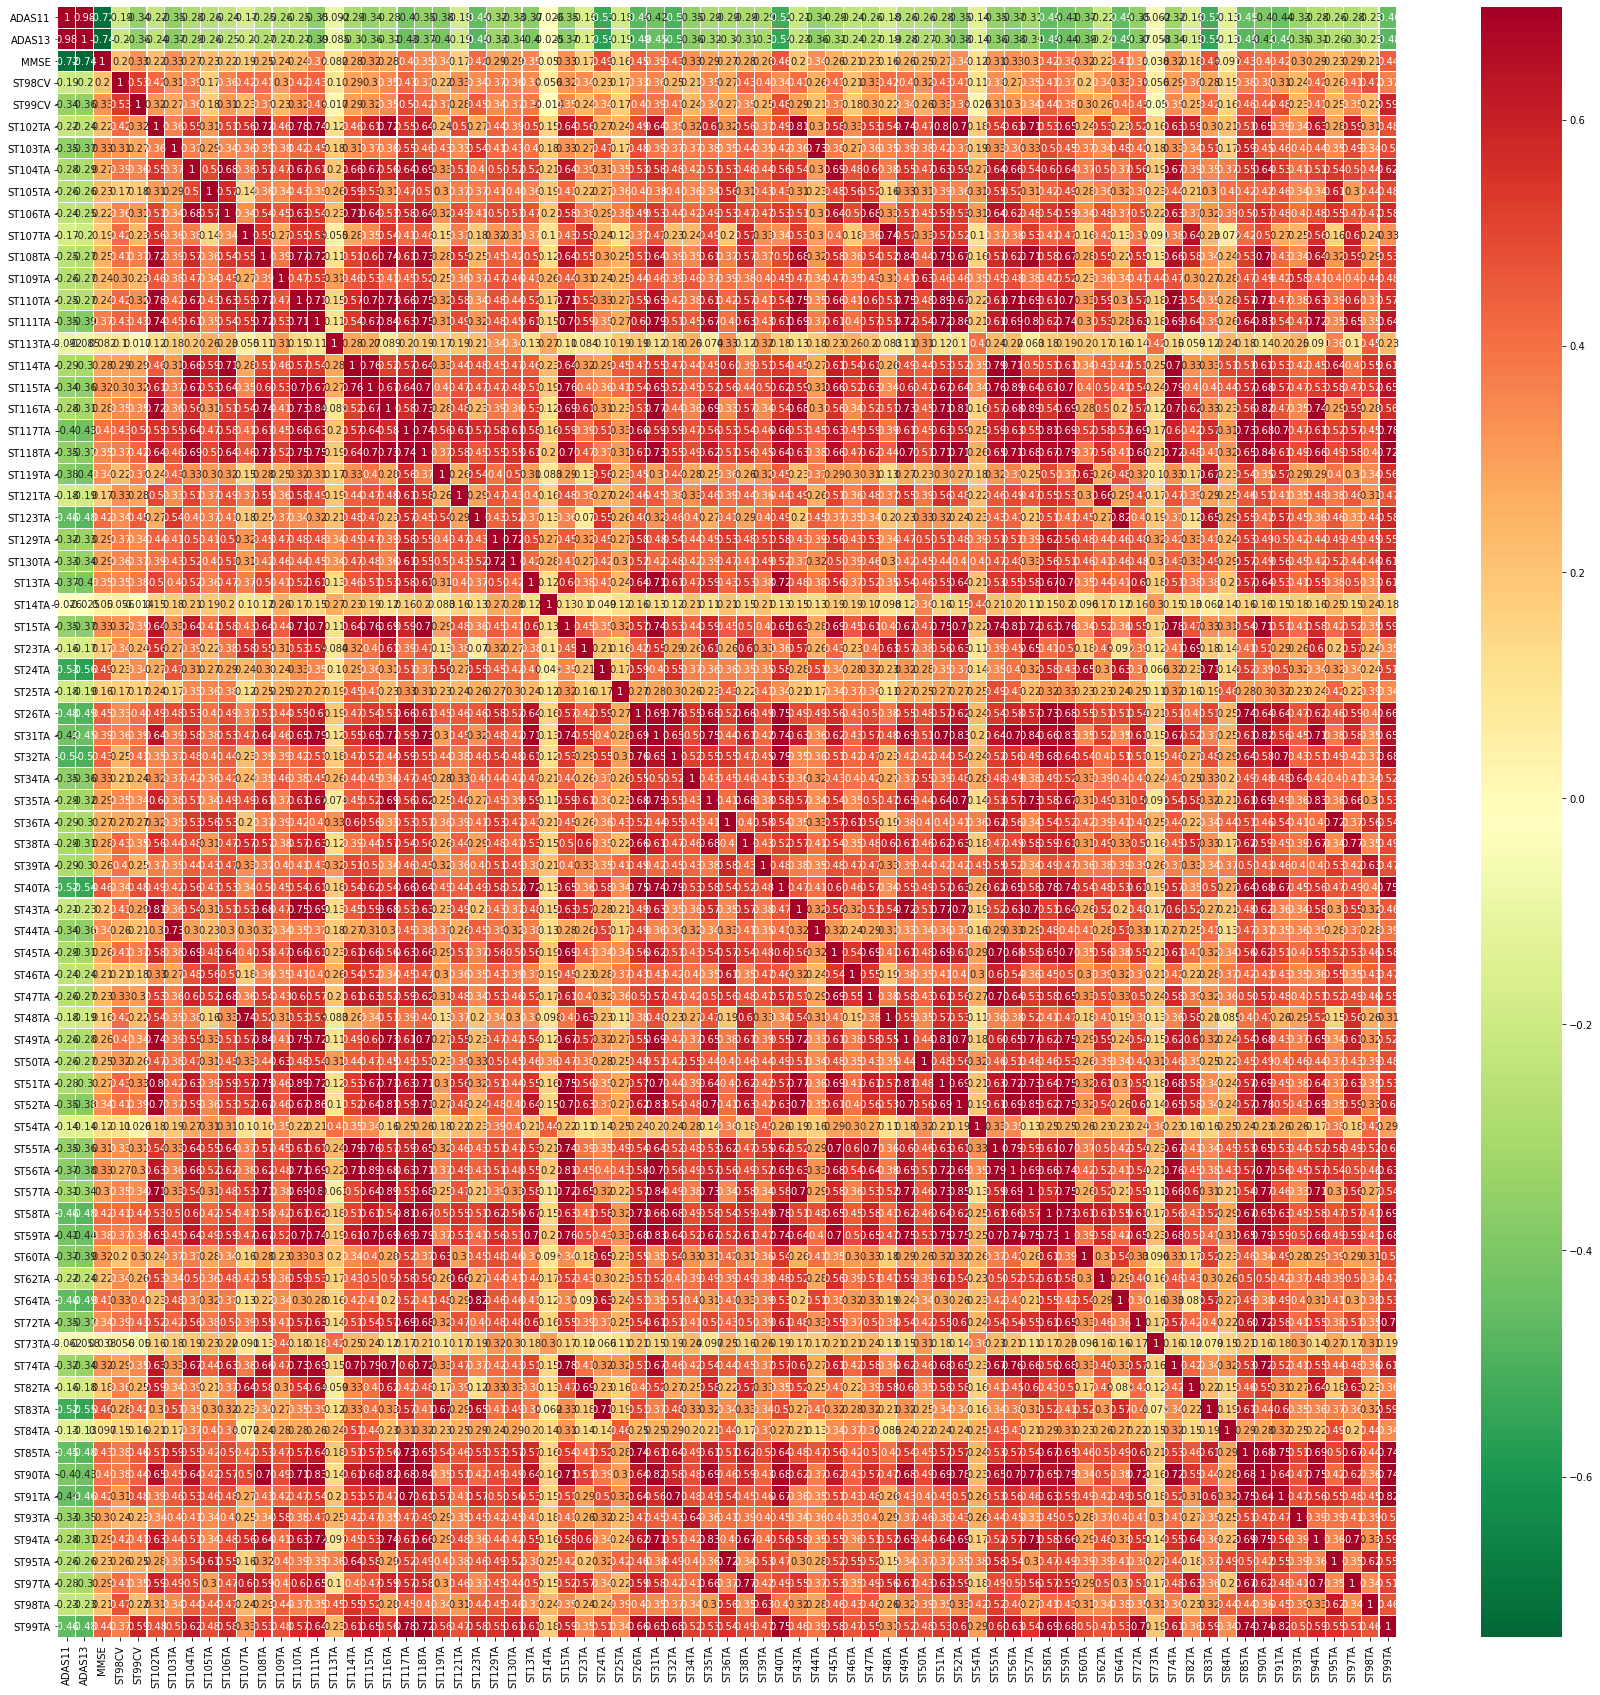

In [ ]:
# Correlation
import seaborn as sns
minMaxScaler = MinMaxScaler()
plt.figure(figsize=(30,30))
df_minmax=pd.DataFrame(minMaxScaler.fit_transform(df),columns=df.columns)
df_sns=pd.concat([df_minmax.iloc[:,:3],df_minmax.iloc[:,71:]],axis=1)
sns.heatmap(df_sns.corr(), linewidths=0.1, vmax=0.7, cmap='RdYlGn_r',linecolor='w', annot=True )

* correlation 이 target 들에 대해 모두 30 이상인 columns 를 추출해봄
* correlation 이 30% 이상인 columns을 추출해보면 TA(28), CV(13)로 TA 가 상관관계가 높은 column 들이 많은 것을 볼 수 있음

In [ ]:
p=0.3
df_corr = df.corr().iloc[:,:3][(np.abs(df.corr()['ADAS11']) > p) & \
                                      (np.abs(df.corr()['ADAS13']) > p) & (np.abs(df.corr()['MMSE']) > p) ]
print(df_corr)

           ADAS11    ADAS13      MMSE
ADAS11   1.000000  0.975137 -0.718490
ADAS13   0.975137  1.000000 -0.742193
MMSE    -0.718490 -0.742193  1.000000
ST103CV -0.314829 -0.333178  0.306767
ST123CV -0.364837 -0.391187  0.361154
ST24CV  -0.438690 -0.464991  0.418972
ST26CV  -0.302687 -0.321045  0.306738
ST31CV  -0.333006 -0.351133  0.323773
ST32CV  -0.361063 -0.372352  0.334919
ST40CV  -0.405671 -0.421270  0.376537
ST44CV  -0.332799 -0.352273  0.327410
ST58CV  -0.308392 -0.320474  0.303268
ST64CV  -0.328580 -0.362396  0.332655
ST83CV  -0.405812 -0.432982  0.370257
ST85CV  -0.327238 -0.341170  0.341265
ST90CV  -0.310017 -0.327362  0.322436
ST91CV  -0.321073 -0.334542  0.317004
ST99CV  -0.342726 -0.356632  0.327640
ST103TA -0.348170 -0.370218  0.333452
ST111TA -0.354874 -0.386315  0.372776
ST115TA -0.343855 -0.362802  0.318099
ST117TA -0.404514 -0.430301  0.395996
ST118TA -0.351921 -0.374664  0.345235
ST119TA -0.380796 -0.404498  0.341661
ST123TA -0.458826 -0.482119  0.416359
ST13TA  -0.3

## II. Function

### Baysian Regression

In [ ]:
def Calculate_w(x,t):
  
  A = np.dot(np.transpose(x), x)
  B = np.dot(np.transpose(x),T)

  return np.dot(np.linalg.inv(A),B)
  
#np.random.seed(1234) 
def Calculate_fully_bayes( pi_x, T, alpha, beta, n):
  '''
  : fully bayesian calculate
  : p(t|x,w,alpha,beta) = N(t|m(x),var)
  '''
  #print('Bayesian Regression start.........',pi_x.shape)

  FB_predict = []
  mu = []
  var = []

  for i in range(3):

    # 공분산
    S_1 = alpha*np.identity(n) + beta*np.dot(pi_x,pi_x.T)
    # 평균
    m_x = beta*np.dot(np.dot(pi_x.T,np.linalg.inv(S_1)),np.dot(pi_x,T.iloc[:,i]))
    mu_t = np.squeeze(m_x.tolist())  # matrix를 list로 만들고 차원을 1차원으로 낮추기
    mu.append(mu_t)
    # 분산
    s_x = 1/beta + np.dot(np.dot(pi_x.T,np.linalg.inv(S_1)),pi_x)
    var_t = np.diag(s_x) # iid 가정이므로 diagonal 값만 뽑아내야됨, 
    #print(s_x,np.array(s_x).shape)
    var.append(var_t) 
    #np.random.seed(1234) 
    FB_predict_t = [ np.random.normal(i,j) for i,j in zip(mu_t, var_t) ]
    FB_predict.append(FB_predict_t)

  return FB_predict, mu, var
 
def MAE(t,y):
  """
  Mean absolute error calculate
  convert to scalar, average
  """
  result=[]

  for i in range(3):

    step=0
    sum=0

    t1=np.array(t.iloc[:,i]).reshape(-1)
    p1=np.array(y[i]).reshape(-1)
    n=len(np.array(t.iloc[:,i]).reshape(-1))
    #print('target no: ',i,'\n','target_data: ',t1,np.array(t1.shape),'\n','real_y: ',p1,np.array(p1.shape))

    for target, predict in zip(t1,p1):
      tmp = np.abs(target-predict)
      sum += tmp
      step += 1

      if ( step % 500 == 0 ):
        ''''''
        #print('step: ',step,target,predict,n,sum)

    result.append(sum/n)
    #print('sum : ',sum, 'final result : ', result,'\n')

  return result


### Data loading & preprocessing

In [ ]:
def origin_data():
    '''
    : load oraginal data
    '''
    #data = 'https://raw.githubusercontent.com/kiakass/share/master/train_data.csv'
    df = pd.read_csv(data)

    return df

def missing_data(df):
    '''
    : handle missing data
    '''
    df_drop=df.dropna(axis=1, thresh=800)
    for i in df_drop.describe().iloc[0][df_drop.describe().iloc[0] < 1607 ].index:
      df_drop[i]=df_drop[i].fillna(df_drop[i].mean())

    return df_drop

def normalize_data(df):

    print('normalize_data start...')
    minMaxScaler = MinMaxScaler()
    df_minmax=pd.DataFrame(minMaxScaler.fit_transform(df),columns=df.columns)

    return df_minmax

def corr_data(df,region):
    print('corr_data start...')
    p=0.3
    df_corr = df.corr().iloc[:,:3][(np.abs(df.corr()['ADAS11']) > p) & \
                                          (np.abs(df.corr()['ADAS13']) > p) & (np.abs(df.corr()['MMSE']) > p) ]
    if region == 'ALL':
      cor_idx=df_corr.index[3:]  # CV, TA extract [[i for i, elem in enumerate(df_corr.index[3:]) if 'CV' in elem]]
    elif region == 'CV' or region =='TA':
      cor_idx=df_corr.index[3:][[i for i, elem in enumerate(df_corr.index[3:]) if region in elem]]

    df_minmax_corr = pd.DataFrame(df, columns=cor_idx) 

    return df_minmax_corr

def preprocess_data(type,region):

  '''
  : choose data type : 'original', 'normalize', 'correlation' )
  '''

  print('preprocessing start',type, region)

  if type == 'original':

      df_final = origin_data()
      print(type)
  
  if type == 'missing':
      '''
      : preprocessing missing data & normalize
      : Missing value : 
      :  drop if missing values > 50%, replace missing value to mean()
      '''
 
      df = origin_data()
      df_drop = missing_data(df)
      df_final = df_drop
      print(type)

  if type == 'normalize':
    '''
    : preprocessing missing data & normalize
    : Missing value : 
    :  drop if missing values > 50%, replace missing value to mean()
    '''
    df = origin_data()
    df_drop = missing_data(df)
    df_minmax = normalize_data(df_drop)
    df_final = df_minmax
    print(type)

  if type == 'corr':
    # correlation > p column
    df = origin_data()
    df_drop = missing_data(df)
    df_minmax = normalize_data(df_drop)
    df_corr = corr_data(df_minmax,region)

    df_final = df_corr
    print(type)
  
  print('Check the data, shape df_final #1 : ', df_final.shape)

  # select input data
  if type != ('corr'):
    df_final = select_data_area(df_final, region)

  print('Check the data, shape df_final #2 : ', df_final.shape,'\n')
  
  return df_final

def select_data_area(df_final, region):
  '''
  : Input data
  : ALL : all, 140 column data 
  : CV  : Cortical Volumn, 대뇌피질크기, 70 column
  : TA  : Average Thickness, 두께, 70 column
  '''
  if region == 'ALL':
    df_final = df_final
    print(region)
  elif region == 'CV':
    df_final = df_final.iloc[:,3:71] # cortical Volumn
    print(region)
  elif region == 'TA':
    df_final = df_final.iloc[:,71:] # Average Thickness
    print(region)
  return df_final

### Basis Function

In [ ]:
def basis_func(x):
  print('basis_func start......',x.shape)
  linear = x
  sigmoid = 1/(1+np.exp(-x))
  tanh = 2*(1/(1+np.exp(-x))) - 1
  swich = x*1/(1+np.exp(-x))
  softplus = np.log(1+np.exp(x))

  return linear, sigmoid , tanh, swich, softplus

## III. Run

### Set Data

In [ ]:
'''
 data preprocessing : 
 preprocess_data ( type, region ) 
  - type : original, missing, normalize, corr
  - region : 'ALL', 'CV':cortical Volumn, 'TA': Average Thickness
'''
def set_data(type, region):
  df_origin = preprocess_data(type,region )

  # X:bias field fomating
  X0=pd.DataFrame(columns=['X0'],index=(i for i in range(df_origin.shape[0]))).fillna(1)

  # create inpu X, target T 
  X=pd.concat([X0,df_origin], axis=1)
  T=df_origin.iloc[:,:3]
  print('set_data :','X shape:',X.shape,'T shape: ',T.shape,'\n')

  return X, T

### Run Bayesain

In [ ]:
# Setting Data
'''
 set_data ( type, region ) 
  - type : original, missing, normalize, corr
  - region : 'ALL', 'CV':cortical Volumn, 'TA': Average Thickness
'''
X, T = set_data('corr','CV')
PI = np.array(basis_func(X)).reshape(-1,X.shape[0],X.shape[1])
print('PI shape : ',PI.shape,'\n')

# init parameter
fn=0
alpha=2
beta=1000

# Run Bayesian Regression
basis_l = [[0,'linear'],[1,'sigmoid'],[2,'tanh'],[3,'swich'],[4,'softplus']]

for bf,bl in zip(PI,np.array(basis_l)[:,1]):
  fn += 1
  FB_predict, mu, var = Calculate_fully_bayes(bf.T,T, alpha, beta, X.shape[1])
  #print('mu:', mu[:5],'\n', 'var:',  var[:5])
  mae_result = MAE(T,FB_predict)
  if fn == 1:
    print('basis func : MAE [ ADAS11 ,  ADAS13  , MMSE ] MAE Average   ################  ' )
  print('{}  {}  {} '.format(bl, mae_result, np.average(mae_result)) )

preprocessing start corr CV
normalize_data start...
corr_data start...
corr
Check the data, shape df_final #1 :  (1607, 13)
Check the data, shape df_final #2 :  (1607, 13) 

set_data : X shape: (1607, 14) T shape:  (1607, 3) 

basis_func start...... (1607, 14)
PI shape :  (5, 1607, 14) 

basis func : MAE [ ADAS11 ,  ADAS13  , MMSE ] MAE Average   ################  
linear  [0.0008341470832232118, 0.0007828061228503122, 0.0008285880606093086]  0.0008151804222276109 
sigmoid  [0.0018618654612899853, 0.0024031208922342786, 0.002521772445938709]  0.0022622529331543244 
tanh  [0.001907855474844885, 0.0024929393615275588, 0.0025704149607929582]  0.002323736599055134 
swich  [0.005198495973445135, 0.007274436218420237, 0.006881703594186977]  0.00645154526201745 
softplus  [0.0032615815364770203, 0.004462100562465865, 0.0042837488994348066]  0.004002476999459231 


## IV.Result

### ■ Model comparison 결과 정리 <br>

> <b><font color="blue"> Data 범위 x Basis func x Parameter 의 경우의 수를 고려하여 모델 성능을 비교하였습니다.</font></b>
<br><br>

***
> <h3><b> CASE I > </b> <font size='3'> 데이터의 범위를 변경 ALL:CV:TA, (α= 2, β= 150) </font> </h3>

>> <b>1. input data 를 모두 사용한 경우 </b> <br>
>>> Condition >  set_data(type = 'normalize', region = 'ALL')

|basis func|Target MAE [ ADAS11 ,  ADAS13  , MMSE ] | avg(MAE)|
 |---|---|---|
| basic |[0.005667053182401433, 0.0056665989931545735, 0.005663518246375066] | 0.005665723473977024 |
|sigmoid |[0.00705163921797435, 0.007074235672601378, 0.008987170406527406] | 0.007704348432367711 
|tanh |[0.0061546831569549345, 0.0062748345860639855, 0.008591922462219586]  |0.007007146735079502 
|swich |[0.00975748533711916, 0.010113739561898, 0.013120294003275447] | 0.01099717296743087 
|softplus |[0.007479393539251437, 0.007651269150910148, 0.009872881534871269] | 0.008334514741677618 

>>> <p><font color="brown"><b> 'ALL' data를 사용한 경우 basis func : linear 의  경우가 MAE 가 가장 낮습니다.</b></font></p>

>> <b>2. 'CV'(Cortical Volumn) data 만 사용한 경우 </b> <br>
>>> Condition >  set_data(type = 'normalize', region = 'CV')

|basis func|Target MAE [ ADAS11 ,  ADAS13  , MMSE ] | avg(MAE)|
|---|---|---|
|linear | [0.00543992171234643, 0.005435213632921449, 0.005436594739990161] | 0.00543724336175268 
|sigmoid | [0.005973559013134019, 0.006001716774070313, 0.005891471517220486]|  0.005955582434808273 
|tanh | [0.005674316448088007, 0.005774864574596909, 0.005642712709884041] | 0.005697297910856319 
|swich | [0.008005002899683967, 0.007610644569152856, 0.007940445339298236] | 0.00785203093604502 
|softplus | [0.006544667558654528, 0.006446363662994886, 0.006545133582436714] | 0.006512054934695376 

>>> <p><font color="brown"><b> 'CV' data를 사용한 경우 basis func : linear 의  경우가 MAE 가 가장 낮습니다.</b></font></p>

>> <b>3. 'TA'(Cortical Volumn) data 만 사용한 경우 </b> <br>
>>> Condition >  set_data(type = 'normalize', region = 'CV')

|basis func|Target MAE [ ADAS11 ,  ADAS13  , MMSE ] | avg(MAE)|
|---|---|---|
|linear | [0.00549083113971425, 0.0056357932658704975, 0.0054520133628728415]  |0.005526212589485863 
|sigmoid | [0.006355402089441127, 0.006971134096731651, 0.006503280974906841] | 0.0066099390536932074 
|tanh | [0.005916247933128932, 0.006736202922199738, 0.006208712653034684] | 0.006287054502787785 
|swich | [0.008152143109327263, 0.009629589143952835, 0.007837312802693404] | 0.0085396816853245 
|softplus | [0.006557325910051943, 0.007704183207278637, 0.006673890704411564]|  0.006978466607247381

>>> <p><font color="brown"><b> 'TA' data를 사용한 경우 basis func : linear 의  경우가 MAE 가 가장 낮음 </b></font></p>

> <b>[ CASE I : summary ]</b>
> 1. Data 는 <font color="blue"><b>'CV'</b></font> 데이터만 사용하였을 경우 가장 MAE 가 낮게 나왔음
> 2. Basis function 은 <font color="blue"><b>linear model</b></font> 인 경우 성능이 가장 좋음
<br><br>

***
<br>

> <h3><b> CASE II > </b> <font size='3'> Correlation data 사용, (α= 2, β= 150) </font> </h3>

|basis func|Target MAE [ ADAS11 ,  ADAS13  , MMSE ] | avg(MAE)|
|---|---|---|
|linear  |[0.005300651888038797, 0.005384201611171256, 0.00539877300164687] | 0.005361208833618974 
|sigmoid | [0.005858221075426596, 0.005984793105691682, 0.006003834587368359]|  0.0059489495894955455 
|tanh  |[0.0057413046732865194, 0.005971126616997172, 0.006039403535417699]  |0.0059172782752337965 
|swich  |[0.007609480590268649, 0.008896701943262057, 0.008638445910506932]  |0.008381542814679213 
|softplus | [0.006396308667610332, 0.007078084275528733, 0.006840137474777357]|  0.006771510139305474 

> <b>[ CASE II : summary ]</b>
> 1. <font color="blue"><b>'corr-CV'</b></font> 데이터를 사용하였을 경우 가장 MAE 가 낮게 나왔음,
>> - correlation 이 높은 13개의 input value 를 사용한 경우가 MAE 최저
<br><br>

***
<br>

> <h3><b> CASE III > </b> <font size='3'> parameter 변경, (α= 2, β= N) </font> </h3>

>> 아래 <b>"Update MAE by alpha, beta value"</b> 에서 beta 와 MAE 값의 관계를 보면 
>> beta 가 증가할수록 MAE 값이 작아지므로 500, 1000 으로 증가시켜 보았음

>> alpha 값의 변화는 성능에 크게 영향이 없는 것으로 판단됨

>>1. α= 2, β= 500

|basis func|Target MAE [ ADAS11 ,  ADAS13  , MMSE ] | avg(MAE)|
|---|---|---|
|linear | [0.001620128822813231, 0.0016016438522911919, 0.0016447733895734195] | 0.0016221820215592808 
|sigmoid | [0.002363224001191951, 0.002887904996658495, 0.002925785001847187] | 0.002725637999899211 
|tanh | [0.002345461217014187, 0.002880433804367698, 0.002946571576590329] | 0.002724155532657405 
|swich | [0.005393703834001783, 0.007456562311712636, 0.007023134472866425] | 0.006624466872860282 
|softplus | [0.0035233737834937796, 0.004635505230912632, 0.004512188342274749] | 0.00422368911889372 

>>> <p><font color="brown"><b>  MAE = 0.0015 </b></font></p>

>>2. α= 2, β= 1000

|basis func|Target MAE [ ADAS11 ,  ADAS13  , MMSE ] | avg(MAE)|
|---|---|---|
|linear | [0.000818940660220513, 0.0007840090890827277, 0.0008001187172583342]|  0.0008010228221871917 
|sigmoid | [0.0018783572127042784, 0.002433151794060516, 0.0025137561277140796] | 0.0022750883781596245 
|tanh | [0.0018931680144819597, 0.002502803433802797, 0.0025447608435649146] | 0.002313577430616557 
|swich | [0.005160999001863498, 0.007282354205601792, 0.006887068747471646] | 0.0064434739849789785 
|softplus | [0.003272080067163258, 0.004472825484817569, 0.0042487254911264885] | 0.003997877014369105 

>>> <p><font color="brown"><b> MAE = 0.0008 </b></font></p>

> <b>[ CASE III : summary ]</b>

>> <b>beta 가 커질수록 MAE 가 낮아지는 것을 볼수 있음</b>

<br><br>

---
<br>

> <h3><b> [ Conclusion ]  </b> <font size='3'>  </font> </h3>

> ■ Model result
>> * Final MAE : 0.0008 <br>
>> * Data : CV correlation 이 높은 13개 필드 사용 <br>
>> * Model : Linear <br><br>

> ■ After Work
>> * Bayesian 외에 다른 regression model 과 비교해 보면 좋을 것 같습니다.
>> * Gradient Descent 방법을 추가적으로 사용
>> * alpha, beta 를 구하는 공식을 프로그램밍 해서 사용


## ETC

### Find alpha, beta

alpha(1<α<10), beta(0<β<200) 의 범위를 정하고 <br>Random하게 조합 및 iteration 을 통해 최적의 성능 조합을 찾아보고 도식화 해보았음

In [ ]:
import random
alpha_list=np.linspace(1,10,100)
beta_list=np.linspace(10,500,100)
param=[]

for i in range(200):
  tmp=[random.choice(alpha_list),random.choice(beta_list)]
  param.append(tmp)

PI = np.array(basis_func(X)).reshape(-1,X.shape[0],X.shape[1])
fn=0
total_sum=[]


for bf in PI:
  #print(np.array(bf).shape, bf)
  fn += 1
  result_sum=[]
  for alpha,beta in param:
    
    FB_predict, mu, var = Calculate_fully_bayes(bf.T,T, alpha, beta, X.shape[1])
    #print('mu:', mu[:5],'\n', 'var:',  var[:5])
    mae_result = MAE(T,FB_predict)  # sum(t-p)/n
    tmp = np.average(mae_result)
    result_sum.append([alpha,beta,tmp])

  total_sum.append(result_sum)
  print('basis_func #{} : {} average:  {} '.format(fn, mae_result, np.average(mae_result)) )

basis_func start...... (1607, 14)
basis_func #1 : [0.009317147916363278, 0.008825844987002427, 0.00873980749867774] average:  0.008960933467347816 
basis_func #2 : [0.009486620347096445, 0.009292659247478272, 0.009399734908335908] average:  0.009393004834303541 
basis_func #3 : [0.009292948223595748, 0.009437150164489884, 0.009967436022247318] average:  0.009565844803444317 
basis_func #4 : [0.010951083916750474, 0.01200695109482741, 0.01150914961457652] average:  0.011489061542051468 
basis_func #5 : [0.009818521360055146, 0.010373747210158787, 0.009955635699423246] average:  0.010049301423212392 


### Update MAE by alpha, beta value

* basis func. 및 alpha, beta 에 따른 MAE 의 변화를 그래프로 시각화하였음. <br>
alpha 의 값으로 인한 MAE 의 변화는 없고,
beta 가 커짐에 따라 MAE 가 감소하는 것을 볼 수 있음, beta > 500

0 linear
1 sigmoid
2 tanh
3 swich
4 softplus


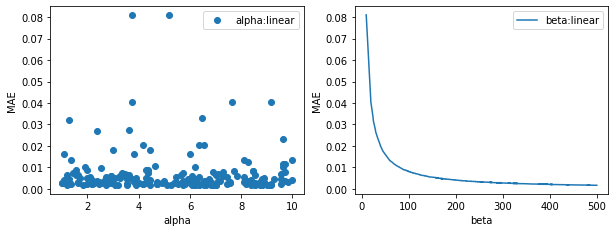

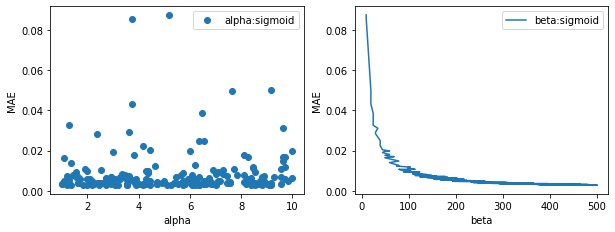

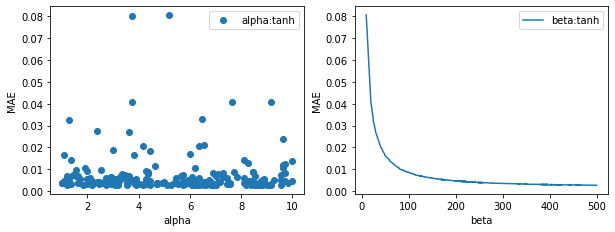

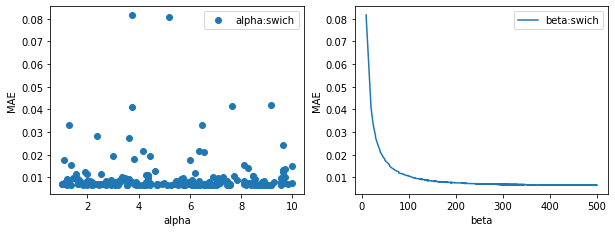

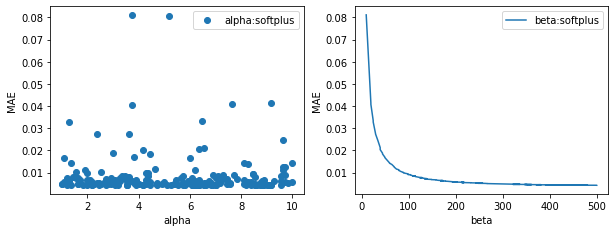

In [ ]:
basis_l = [[0,'linear'],[1,'sigmoid'],[2,'tanh'],[3,'swich'],[4,'softplus']]

p_alpha=[]
p_beta=[]
p_mae=[]

for i,j in basis_l:
  test=total_sum[i] # tanh mae
  test.sort(key = lambda x:x[2])
  p_alpha.append(np.array(test)[:,0])
  p_beta.append(np.array(test)[:,1])
  p_mae.append(np.array(test)[:,2])
  fig=plt.figure(figsize=(10,20))
  print(i,j)

  plt.subplot(5,2,2*i+1);plt.plot(p_alpha[i],p_mae[i], 'o', label='alpha:'+j)
  plt.legend(loc='upper right')
  plt.xlabel('alpha')
  plt.ylabel('MAE')

  plt.subplot(5,2,2*i+2);plt.plot(p_beta[i],p_mae[i], '-', label='beta:'+j)
  plt.legend()
  plt.xlabel('beta')
  plt.ylabel('MAE')

plt.show()

### show alpha, beta, min(mae) value

In [ ]:
for i,j in basis_l:
  total_sum[1].sort(key = lambda x:x[2])
  print('basis func : ',j)
  print('alpha,beta,mae min 10 list : ','\n',np.array(total_sum[1][:10]),'\n')

basis func :  linear
alpha,beta,mae min 10 list :  
 [[3.90909091e+00 5.00000000e+02 2.69211699e-03]
 [3.09090909e+00 4.95050505e+02 2.71664662e-03]
 [5.72727273e+00 5.00000000e+02 2.76134070e-03]
 [1.81818182e+00 4.60404040e+02 2.80064433e-03]
 [3.18181818e+00 4.55454545e+02 2.81558741e-03]
 [1.18181818e+00 4.35656566e+02 2.82761200e-03]
 [6.36363636e+00 4.95050505e+02 2.83493519e-03]
 [6.18181818e+00 4.80202020e+02 2.83525672e-03]
 [7.00000000e+00 5.00000000e+02 2.83889568e-03]
 [6.09090909e+00 4.65353535e+02 2.86820910e-03]] 

basis func :  sigmoid
alpha,beta,mae min 10 list :  
 [[3.90909091e+00 5.00000000e+02 2.69211699e-03]
 [3.09090909e+00 4.95050505e+02 2.71664662e-03]
 [5.72727273e+00 5.00000000e+02 2.76134070e-03]
 [1.81818182e+00 4.60404040e+02 2.80064433e-03]
 [3.18181818e+00 4.55454545e+02 2.81558741e-03]
 [1.18181818e+00 4.35656566e+02 2.82761200e-03]
 [6.36363636e+00 4.95050505e+02 2.83493519e-03]
 [6.18181818e+00 4.80202020e+02 2.83525672e-03]
 [7.00000000e+00 5.0000000

### alpha upate를 위한 igenvalue

PI(Φ) 의 igenvalue 를 구하였으나, matrix 계산식이 구현하기 어려움


In [ ]:
s,v =np.linalg.eig(beta*np.dot(np.array(PI[0]).T,np.array(PI[0])))

In [ ]:
v

array([[ 0.51326187,  0.76444544, -0.29718037,  0.00850332,  0.07663885,
        -0.12240351, -0.10746052,  0.05859359,  0.06282661, -0.12926885,
        -0.0227516 , -0.03386233,  0.06521757, -0.03721011],
       [ 0.22307277,  0.00816686,  0.30819446, -0.241076  , -0.38400307,
         0.52495961,  0.21163317,  0.35602041,  0.24602944, -0.33136196,
        -0.11040797, -0.02993111,  0.02444598, -0.1359252 ],
       [ 0.21984175, -0.06476958,  0.58863575,  0.02887646,  0.46078393,
        -0.40794326,  0.24171806,  0.03458886,  0.10636491, -0.21786   ,
         0.13961085, -0.25752604,  0.09976398, -0.08511694],
       [ 0.23600596, -0.22431209,  0.01418026, -0.41920899, -0.35696711,
        -0.53775943, -0.20807036,  0.24930633, -0.10896872,  0.2101679 ,
        -0.06815303,  0.19091339,  0.18739586, -0.25245926],
       [ 0.25821352, -0.27565761, -0.31733996, -0.30411304,  0.50379546,
         0.15017942,  0.18039801, -0.08191337,  0.18529365,  0.08002928,
        -0.24156251,  0.20

In [ ]:
s/(alpha+s)

array([0.99999708, 0.99975108, 0.9995427 , 0.99918234, 0.9990209 ,
       0.99893003, 0.99885463, 0.9970316 , 0.99742308, 0.99771303,
       0.99864364, 0.99845121, 0.99810182, 0.99826661])